# Get Started

[Contrails API](https://api.contrails.org) is a RESTful API that provides contrail modeling and mitigation tools.

This notebook shows basic usage of Contrails API from a [Python notebook](https://jupyter.org/) using the [requests](https://pypi.org/project/requests/) package to send HTTP requests.

You can interact with Contrails API any HTTP compatible client (i.e. [curl](https://curl.se/), [Postman](https://www.postman.com/product/tools/)).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/contrailcirrus/2023-04-pycontrails-workshop/blob/main/notebooks/04-API-Get-started.ipynb)

## Authorization

- Your API key must be provided as `api_key` query parameter or `x-api-key` request header.

In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install requests

In [1]:
import os
from pprint import pprint

In [2]:
URL = "https://api.contrails.org/v0"
api_key = "<ADD API KEY">
headers = {"x-api-key": api_key}

### Validate key

**GET [/auth/validate](https://api.contrails.org/openapi#/Authorization/validate_api_key_v0_auth_validate_key_get)**

As a first step, we can check if our key is valid. You'll see a 200 response if it is.

This can also be achieved with `curl` directly from the command line.

```bash
curl -H "x-api-key: $CONTRAILS_API_KEY" -H "Accept: application/json" "https://api.contrails.earth/v0/auth/validate-key"
```

In [3]:
import requests  # pip install requests

In [4]:
r = requests.get(f"{URL}/auth/validate-key", headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")

HTTP Response Code: 200 OK


## Trajectory API

Endpoints in the `/trajectory/` API each require POST requests. The POST body defines an individual flight: A sequence of discrete temporal spatial waypoints describing the 1D flight trajectory. See the [Fleet Computation](https://apidocs.contrails.org/notebooks/fleet_mode.html) guide for posting multiple distinct flights in one request.

The request body defines the parameterization of the flight into discrete waypoints. Responses use the same parameterization defined by the request body. For example, if a flight with 85 waypoints is passed into the `/trajectory/issr` endpoint, the response object will contain 85 ISSR predictions. These are in one-to-one corresponding with the request body.

We create a synthetic flight to use in this notebook as an example.

Not every field defined in the `flight` dictionary below is required for each endpoint. Apart from the four necessary temporal spatial fields (`longitude`, `latitude`, `altitude`, `time`), additional aircraft performance variables (`engine_efficiency`, `aircraft_mass`, ...) can be array-like (of the same length as the temporal spatial fields) or scalar-like if a constant value is to be used for all waypoints.

In [5]:
import numpy as np  # pip install numpy
import pandas as pd  # pip install pandas
import matplotlib.pyplot as plt  # pip install matplotlib

In [6]:
n_waypoints = 100
t0 = "2022-06-07T00:15:00"
t1 = "2022-06-07T02:30:00"

flight = {
    "longitude": np.linspace(-29, -50, n_waypoints).tolist(),
    "latitude": np.linspace(45, 42, n_waypoints).tolist(),
    "altitude": np.linspace(33000, 38000, n_waypoints).tolist(),
    "time": pd.date_range(t0, t1, periods=n_waypoints).astype(str).tolist(),
    "engine_efficiency": np.random.default_rng(42).uniform(0.3, 0.4, n_waypoints).tolist(),
    "aircraft_mass": np.linspace(64900, 64500, n_waypoints).tolist(),
    "aircraft_type": "A320",
}

### SAC

**POST [/trajectory/sac](https://api.contrails.org/openapi#/Trajectory/schmidt_appleman_contrail_formation_criteria_v0_trajectory_sac_post)**

This endpoint calculates Schmidt-Appleman contrail formation criteria (SAC) along a flight trajectory.

The SAC is a binary model that indicates whether the flight forms an initial contrail. In particular, we use the following conventions.

- A value of 1 indicates the waypoint satisfies the SAC.
- A value of 0 indicates the waypoint does not satisfy the SAC.
- A null value indicates that the SAC state is not known for the waypoint. This most often occurs at terminal waypoints when engine efficiency is not known, or when the waypoint is not contained within the domain of the meteorology data.

[Engine efficiency](https://elib.dlr.de/9247/1/aerscitech-2000.pdf) is a critical parameter for the SAC. If the `engine_efficiency` field is not provided, it calculated via an aircraft performance model from the flight trajectory and the `aircraft_type` field.

In [7]:
r = requests.post(f"{URL}/trajectory/sac", json=flight, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

r_json = r.json()
for k, v in r_json.items():
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

flight_id: 1680642412705001
met_source: ERA5
pycontrails_version: 0.39.6.dev4
humidity_scaling_name: exponential_boost_latitude_customization
humidity_scaling_formula: rhi -> (rhi / rhi_adj) ^ rhi_boost_exponent
sac: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


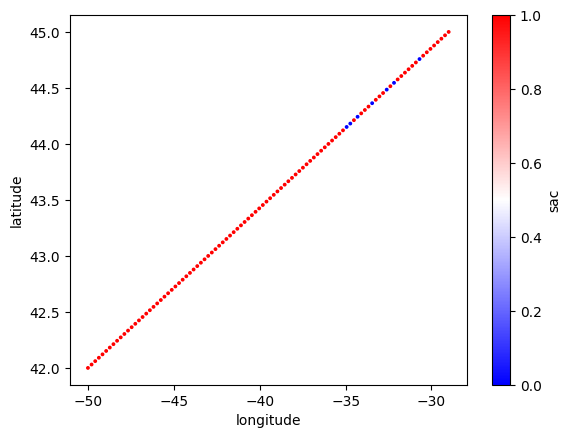

In [8]:
flight_df = pd.DataFrame(flight).assign(sac=r_json["sac"])
flight_df.plot.scatter(x="longitude", y="latitude", c="sac", cmap="bwr", s=3);

### ISSR

**POST [/trajectory/issr](https://api.contrails.org/openapi#/Trajectory/ice_super_saturated_regions_v0_trajectory_issr_post)**

This endpoint calculates ice super-saturated regions (ISSR) along a flight trajectory. Waypoints for which the ambient atmosphere has relative humidity over ice greater than 100% are considered to be in an ISSR.

We use the same value conventions as with the [SAC model](#SAC).

In [9]:
r = requests.post(f"{URL}/trajectory/issr", json=flight, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

r_json = r.json()
for k, v in r_json.items():
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

flight_id: 1680642418123330
met_source: ERA5
pycontrails_version: 0.39.6.dev4
humidity_scaling_name: exponential_boost_latitude_customization
humidity_scaling_formula: rhi -> (rhi / rhi_adj) ^ rhi_boost_exponent
issr: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


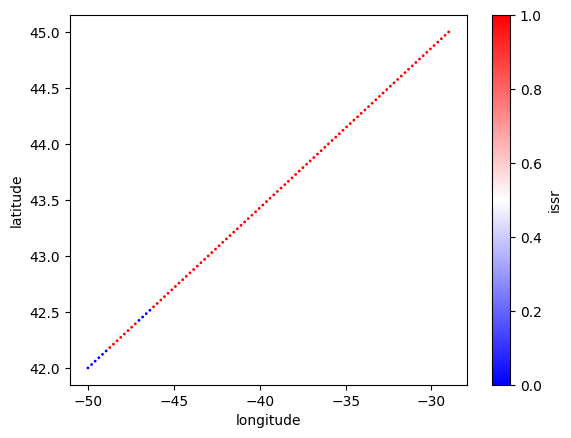

In [10]:
flight_df["issr"] = r_json["issr"]
flight_df.plot.scatter(x="longitude", y="latitude", c="issr", cmap="bwr", s=1);

### CoCiP

**POST [/trajectory/cocip](https://api.contrails.org/openapi#/Trajectory/contrail_cirrus_predictions_v0_trajectory_cocip_post)**

The `/trajectory/cocip` endpoint implements the **Co**ntrail **Ci**rrus **P**rediction (CoCiP) model published in [Schumann 2012](https://gmd.copernicus.org/articles/5/543/2012/) and [Schumann et al 2012](https://journals.ametsoc.org/view/journals/apme/51/7/jamc-d-11-0242.1.xml). The API implementation includes updates from [Schumann 2015](https://acp.copernicus.org/articles/15/11179/2015/), [Teoh 2020](https://pubs.acs.org/doi/10.1021/acs.est.9b05608), and [Teoh 2022](https://acp.copernicus.org/preprints/acp-2022-169/).

The CoCiP model requires more meteorology data and compute time than the other models. Consequently, requesting predictions from the `/trajectory/cocip` endpoint takes some time.

In [11]:
r = requests.post(f"{URL}/trajectory/cocip", json=flight, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")
r_json = r.json()

# The /trajectory/cocip endpoint includes many fields in the response.
for k, v in r_json.items():
    v = str(v)
    if len(v) > 80:
        v = v[:77] + "..."
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

cocip_max_contrail_age: 12 hours
cocip_dt_integration: 10 minutes
flight_id: 1680642420607361
met_source: ERA5
pycontrails_version: 0.39.6.dev4
nvpm_data_source: ICAO EDB
engine_uid: 01P08CM105
humidity_scaling_name: exponential_boost_latitude_customization
humidity_scaling_formula: rhi -> (rhi / rhi_adj) ^ rhi_boost_exponent
sac: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0...
nox_ei: [0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.012, 0.012, 0.012,...
nvpm_ei_n: [1317000000000000.0, 1319000000000000.0, 1319000000000000.0, 1317000000000000...
energy_forcing: [3550000000000.0, 3060000000000.0, 4130000000000.0, 3240000000000.0, 17300000...
contrail_age: [145.0, 144.0, 162.0, 151.0, 150.0, 188.0, 187.0, 0.0, 0.0, 153.0, 151.0, 160...
initially_persistent: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0...


In [12]:
# Energy forcing is the primary model output.
ef = np.array(r_json["energy_forcing"], dtype=float)
ef

array([3.55e+12, 3.06e+12, 4.13e+12, 3.24e+12, 1.73e+12, 4.60e+12,
       4.50e+12, 0.00e+00, 0.00e+00, 2.37e+12, 2.47e+12, 3.67e+12,
       2.95e+12, 3.47e+12, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       3.95e+12, 2.54e+12, 0.00e+00, 0.00e+00, 1.99e+12, 1.92e+12,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.90e+12,
       2.16e+12, 5.00e+10, 5.00e+10, 4.00e+10, 4.00e+10, 4.00e+10,
       5.00e+10, 6.00e+10, 1.20e+11, 2.73e+12, 2.29e+12, 3.42e+12,
       4.11e+12, 4.28e+12, 6.43e+12, 7.26e+12, 7.52e+12, 8.72e+12,
       8.90e+12, 8.61e+12, 8.77e+12, 8.27e+12, 8.46e+12, 7.87e+12,
       7.95e+12, 3.68e+12, 3.01e+12, 1.85e+12, 1.04e+12, 4.80e+11,
       3.90e+11, 3.50e+11, 3.10e+11, 3.10e+11, 3.20e+11, 3.40e+11,
       4.00e+11, 3.80e+11, 3.00e+11, 2.40e+11, 1.90e+11, 1.70e+11,
       1.10e+11, 6.00e+10, 4.00e+10, 3.00e+10, 3.00e+10, 3.00e+10,
       3.00e+10, 2.00e+10, 1.00e+10, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e

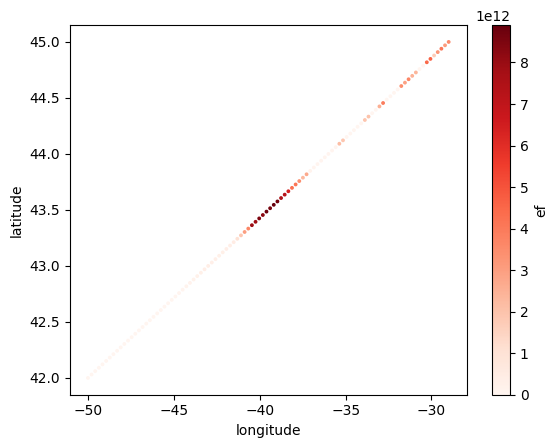

In [13]:
flight_df["ef"] = ef
flight_df.plot.scatter(x="longitude", y="latitude", c="ef", cmap="Reds", s=3);

### Emissions

**POST [/trajectory/emissions](https://api.contrails.org/openapi#/Trajectory/emissions_v0_trajectory_emissions_post)**

The `/trajectory/emissions` endpoint implements the aircraft performance models described in [Teoh 2020](https://pubs.acs.org/doi/10.1021/acs.est.9b05608) and [Teoh 2022](https://acp.copernicus.org/preprints/acp-2022-169/).

Presently, the emissions endpoint provides per-waypoint predictions for NOx and nvPM emissions. These values are derived from the [ICAO Aircraft Engine Emissions Databank](https://www.easa.europa.eu/en/domains/environment/icao-aircraft-engine-emissions-databank). An `engine_uid` field can be supplied to specify the engine type to query the databank. If not provided, the API will assume the engine is the most common engine associated with the aircraft type. Below, we don't supply the `engine_uid`, and so it is included in the response.

In [14]:
r = requests.post(f"{URL}/trajectory/emissions", json=flight, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

r_json = r.json()
for k, v in r_json.items():
    v = str(v)
    if len(v) > 80:
        v = v[:77] + "..."
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

flight_id: 1680642472289409
met_source: ERA5
pycontrails_version: 0.39.6.dev4
nvpm_data_source: ICAO EDB
engine_uid: 01P08CM105
humidity_scaling_name: exponential_boost_latitude_customization
humidity_scaling_formula: rhi -> (rhi / rhi_adj) ^ rhi_boost_exponent
nox_ei: [0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.012, 0.012, 0.012,...
nvpm_ei_n: [1317000000000000.0, 1319000000000000.0, 1319000000000000.0, 1317000000000000...


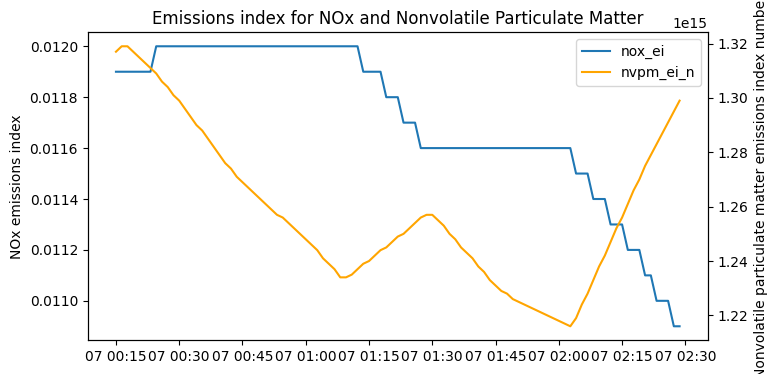

In [15]:
time = pd.to_datetime(flight["time"])

fig, ax = plt.subplots(figsize=(8, 4))
lines = ax.plot(time, r_json["nox_ei"], label="nox_ei")

ax2 = ax.twinx()
lines += ax2.plot(time, r_json["nvpm_ei_n"], color="orange", label="nvpm_ei_n")

labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=0)

ax.set_ylabel("NOx emissions index")
ax2.set_ylabel("Nonvolatile particulate matter emissions index number")
ax.set_title("Emissions index for NOx and Nonvolatile Particulate Matter");

## Grid API

Grid endpoints evaluate a model of interest over a 4D temporal spatial grid. Presently, each grid endpoint requires a single timestamp, and so the grid's time coordinate contains a single value.

Unlike the trajectory endpoints, each grid endpoint is a GET request requiring query parameters. Commonly used query parameters include:

- `time`: the timestamp for the grid. Must be an ISO 8601 datetime string or unix timestamp (seconds since epoch).
- `flight_level`: one or multiple flight levels used to downselect the vertical coordinate of the grid. Must be a comma-separated string or list of integers. Available flight levels are 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440. If not provided, all flight levels are included in the response.
- `bbox`: a horizontal bounding box for the grid. Must be a comma-separated string or list of length 4. The order of the coordinates is `[min_lon, min_lat, max_lon, max_lat]`. The default is the bounding box of the entire domain (most of the entire globe).
- `format`: the format of the response data. This is a case-sensitive string (must be **lower-case**). Valid choices are:
  - `netcdf`: the response is a [netCDF](https://www.unidata.ucar.edu/software/netcdf/) file. This is the default.
  - `json`: the response is a JSON representation of the netCDF file. This format is not recommended.
  - `geojson`: the response is [GeoJSON](https://geojson.org/) polygons. See below for examples of GeoJSON responses.
  - `kml`: the response is a [KML](https://developers.google.com/kml/documentation/kml_tut) representation of the GeoJSON polygons.
- `met_source`: the meteorology source used to compute the model (See [Data Availability](#Data-Availability) for more information). This is a case-sensitive string (must be **upper-case**). Valid choices are:
  - `ERA5`: the model is computed with [ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) meteorology. The latest ERA5 data is only available starting about 5 days into the past. This is the default.
  - `HRES`: the model is computed with [HRES](https://www.ecmwf.int/en/forecasts/datasets/set-i) meteorology. This allows for model forecasts up to 1 - 2 days into the future.

Examples of netCDF and GeoJSON responses are shown below.

### SAC

**GET [/grid/sac](https://api.contrails.org/openapi#/Grid/schmidt_appleman_contrail_formation_criteria_v0_grid_sac_get)**

The SAC, ISSR, and PCR grid endpoints all use similar conventions. We demonstrate the SAC grid endpoint here.

This endpoint accepts an optional `engine_efficiency` parameter that takes a default value of 0.3.

In [16]:
import xarray as xr  # pip install xarray

In [17]:
time = "2022-06-07T02"
bbox = "-50,0,50,50"
params = {"time": time, "bbox": bbox, "engine_efficiency": 0.32}
r = requests.get(f"{URL}/grid/sac", headers=headers, params=params)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
print(f"Response content-type: {r.headers['content-type']}")

HTTP Response Code: 200 OK
Response content-type: application/netcdf


#### netCDF Response Format

The default response format is netCDF. For the SAC endpoint, the 4D grid holds a single `sac` variable. The response can be written out and read with `xarray`.

In [18]:
with open("sac.nc", "wb") as f:
    f.write(r.content)

da = xr.open_dataarray("sac.nc", engine="netcdf4")  # pip install netCDF4
da.coords  # each netCDF served in the API is a 4D grid

Coordinates:
  * time          (time) datetime64[ns] 2022-06-07T02:00:00
  * latitude      (latitude) float32 0.0 0.25 0.5 0.75 ... 49.25 49.5 49.75 50.0
  * longitude     (longitude) float32 -50.0 -49.75 -49.5 ... 49.5 49.75 50.0
  * flight_level  (flight_level) int32 270 280 290 300 310 ... 410 420 430 440

In [19]:
# The grid contains 18 flight levels ranging from 270 to 440.
da.flight_level.values

array([270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440], dtype=int32)

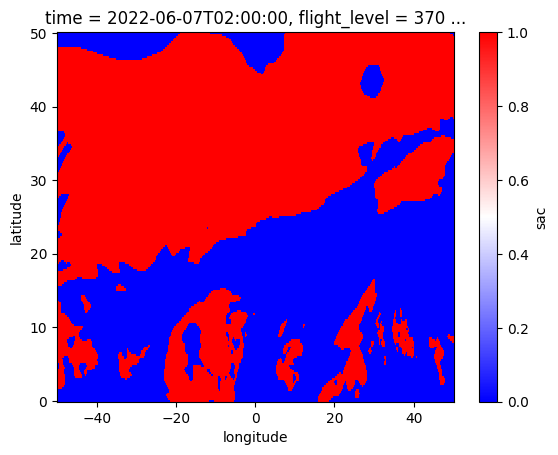

In [20]:
# We "squeeze" on time and select a single flight level to plot.
da.squeeze("time").isel(flight_level=10).plot(x="longitude", y="latitude", cmap="bwr");

#### GeoJSON Response Format

Contrails API supports two types of polygon formats: [GeoJSON](https://geojson.org/) and [KML](https://developers.google.com/kml/documentation/kml_tut).

We demonstrate the same grid endpoint using the GeoJSON representation here.

See the [polygon documentation](https://apidocs.contrails.org/notebooks/polygons.html) for additional examples including custom polygon simplification.

In [21]:
params["format"] = "geojson"
r = requests.get(f"{URL}/grid/sac", headers=headers, params=params)

print(f"HTTP Response Code: {r.status_code} {r.reason}")
print(f"Response content-type: {r.headers['content-type']}")

r_json = r.json()

HTTP Response Code: 200 OK
Response content-type: application/json


In [22]:
import shapely.geometry as sgeom  # pip install shapely

GeoJSON type: FeatureCollection
{'description': 'Schmidt-Appleman contrail formation criteria',
 'engine_efficiency': 0.32,
 'humidity_scaling_formula': 'rhi -> (rhi / rhi_adj) ^ rhi_boost_exponent',
 'humidity_scaling_name': 'exponential_boost_latitude_customization',
 'humidity_scaling_rhi_a0': 0.062621,
 'humidity_scaling_rhi_a1': 0.45893,
 'humidity_scaling_rhi_a2': 39.254,
 'humidity_scaling_rhi_a3': 0.95224,
 'humidity_scaling_rhi_b0': 1.4706,
 'humidity_scaling_rhi_b1': 0.44312,
 'humidity_scaling_rhi_b2': 18.755,
 'humidity_scaling_rhi_b3': 1.4325,
 'level': 350,
 'level_long_name': 'Flight Level',
 'level_standard_name': 'FL',
 'level_units': 'hectofeet',
 'met_source': 'ERA5',
 'name': 'sac',
 'polygon_iso_value': 0.5,
 'pycontrails_version': '0.39.6.dev4',
 'time': '2022-06-07T02:00:00Z'}


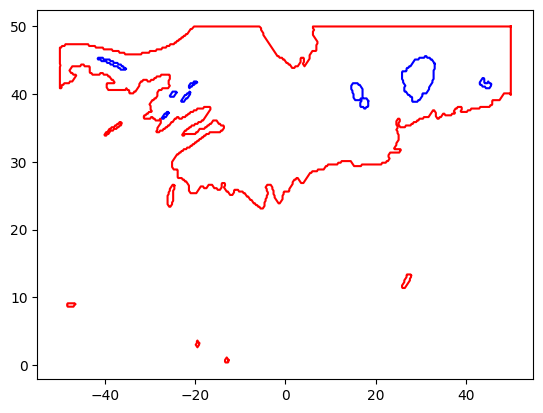

In [23]:
# The response body is a GeoJSON FeatureCollection. Each feature contains polygons for each flight level.
print(f"GeoJSON type: {r_json['type']}")

# Extract a feature
feature = r_json["features"][8]
pprint(feature["properties"])  # print out the metadata

# Visualize with shapely
# Polygons can have both exterior and interior rings
polygons = sgeom.shape(feature["geometry"])
for poly in polygons.geoms:
    plt.plot(*poly.exterior.xy, color="red")  # color exterior red
    for interior in poly.interiors:
        plt.plot(*interior.xy, color="blue")  # and interior blue

### CoCiP

**GET [/grid/cocip](https://api.contrails.org/openapi#/Grid/contrail_cirrus_predictions_v0_grid_cocip_get)**

The **gridded CoCiP** model is an abstraction of the [**original CoCiP** model](https://gmd.copernicus.org/articles/5/543/2012/). Instead of working with a single flight trajectory, the gridded version starts with a 4D vector field of trajectory segments each assumed to be in a nominal cruising state. The gridded model then evolves the segments over time using the same rules as the classical model.

Given a fixed trajectory, the original CoCiP model gives a precise prediction of contrail climate forcing resulting from that trajectory. Consequently, the `/trajectory/cocip` endpoint should be favored when evaluating contrail forcing of a single flight. On the other hand, the gridded CoCiP model can be used to optimize an unknown trajectory over a 4D grid. The two models widely agree when a flight is in a nominal cruising state.

The `/grid/cocip` endpoints requires an `aircraft_type` query parameter for CoCiP initialization.

Unlike all other endpoints, the model underpinning the `/grid/cocip` endpoint has been precomputed. Only a limited set of 11 aircraft types are currently available.

- A320
- A20N
- A321
- A319
- A21N
- A333
- A350
- B737
- B738
- B789
- B77W


#### netCDF Response Format

In [24]:
params["aircraft_type"] = "A320"
params["format"] = "netcdf"

r = requests.get(f"{URL}/grid/cocip", params=params, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
print(f"Content type: {r.headers['content-type']}")

HTTP Response Code: 200 OK
Content type: application/netcdf


In [25]:
with open("cocipgrid.nc", "wb") as f:
    f.write(r.content)

ds = xr.open_dataset("cocipgrid.nc", engine="netcdf4")
ds.data_vars  # The CoCiP data comes with both energy forcing and contrail age

Data variables:
    ef_per_m      (longitude, latitude, flight_level, time) float32 ...
    contrail_age  (longitude, latitude, flight_level, time) timedelta64[ns] ...

{'aircraft_type': 'A320',
 'cocip_dt_integration': '5 minutes',
 'cocip_max_contrail_age': '12 hours',
 'humidity_scaling_formula': 'rhi -> (rhi / rhi_adj) ^ rhi_boost_exponent',
 'humidity_scaling_name': 'exponential_boost_latitude_customization',
 'long_name': 'Energy forcing per meter of flight trajectory',
 'met_source': 'ERA5',
 'name': 'cocip',
 'pycontrails_version': '0.32.2',
 'units': 'J / m'}


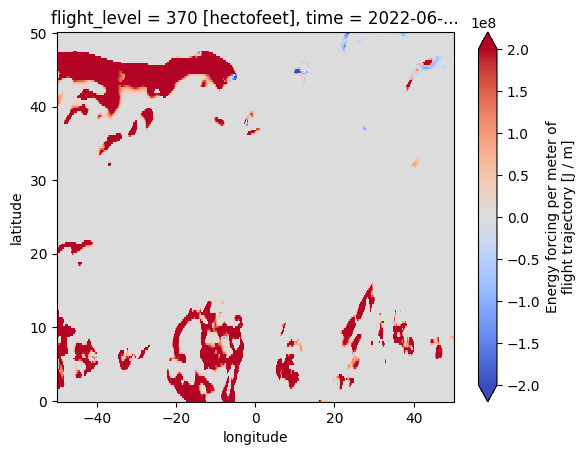

In [26]:
# The energy forcing variable is the primary model output.
da = ds["ef_per_m"]

# Print some metadata present in the netCDF
pprint(ds.attrs | da.attrs)

# We "squeeze" on time and select a single flight level to plot.
da.squeeze("time").isel(flight_level=10).plot(
    x="longitude", y="latitude", vmin=-2e8, vmax=2e8, cmap="coolwarm"
);

#### GeoJSON Response Format

We can specify an energy forcing `threshold` parameter when calling the endpoint. The response contains just polygons surrounding grid cells at which the `ef_per_m` exceeds the threshold.

In converting from the grid representation to the polygon representation, we exclude degenerate polygons and polygons whose area is doesn't exceeds some minimal threshold. Excluding these edge cases allows us to focus on regions of high impact. See the [polygon documentation](https://apidocs.contrails.org/notebooks/polygons.html) for additional polygon simplification examples.

In [27]:
params["format"] = "geojson"
params["threshold"] = 2e8
r = requests.get(f"{URL}/grid/cocip", headers=headers, params=params)

print(f"HTTP Response Code: {r.status_code} {r.reason}")
print(f"Response content-type: {r.headers['content-type']}")
r_json = r.json()

HTTP Response Code: 200 OK
Response content-type: application/json


{'aircraft_type': 'A320',
 'cocip_dt_integration': '5 minutes',
 'cocip_max_contrail_age': '12 hours',
 'humidity_scaling_formula': 'rhi -> (rhi / rhi_adj) ^ rhi_boost_exponent',
 'humidity_scaling_name': 'exponential_boost_latitude_customization',
 'level': 370,
 'level_long_name': 'Flight Level',
 'level_standard_name': 'FL',
 'level_units': 'hectofeet',
 'long_name': 'Energy forcing per meter of flight trajectory',
 'met_source': 'ERA5',
 'name': 'ef_per_m',
 'polygon_iso_value': 200000000.0,
 'pycontrails_version': '0.32.2',
 'time': '2022-06-07T02:00:00Z',
 'units': 'J / m'}


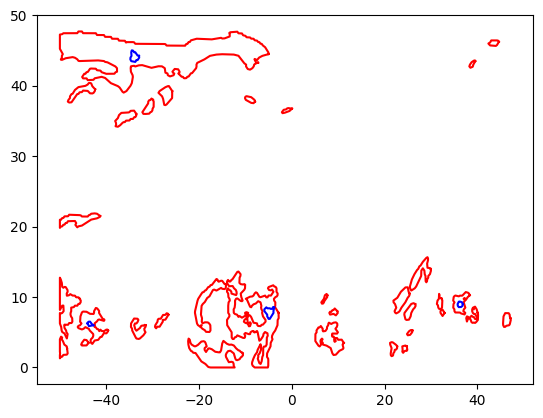

In [28]:
# Extract a feature
feature = r_json["features"][10]
pprint(feature["properties"])  # print out the metadata

# Visualize. We see polygons around regions of dark red in the previous plot.
polygons = sgeom.shape(feature["geometry"])
for poly in polygons.geoms:
    plt.plot(*poly.exterior.xy, color="red")  # color exterior red
    for interior in poly.interiors:
        plt.plot(*interior.xy, color="blue")  # and interior blue

### Data Availability

**GET [/grid/availability](https://api.contrails.org/openapi#/Grid/grid_data_availability_v0_grid_availability_get)**

Grid endpoints in Contrails API serve data with varying availability. This availability depends on both the `time` and `met_source` query parameters. The `/grid/availability` endpoint gives a range of times for which each `/grid` endpoint serves data with a given `met_source`. Set `met_source="HRES"` for contrail forecasts and `met_source="ERA5"` for contrail hindcasts. Typically, HRES data is available 24 - 36 hours into the future, while the latest ERA5 data is only available about 5 days into the past. The `/grid/availability` makes this precise.


In [29]:
# NBVAL_SKIP
r = requests.get(f"{URL}/grid/availability", headers=headers)

print(f"HTTP Response Code: {r.status_code} {r.reason}")
pprint(r.json())

HTTP Response Code: 200 OK
{'cocip': {'ERA5': ['2022-01-01T00:00:00Z', '2023-03-28T22:00:00Z'],
           'HRES': ['2022-12-12T00:00:00Z', '2023-04-05T17:00:00Z']},
 'issr': {'ERA5': ['2018-01-01T00:00:00Z', '2023-03-29T11:00:00Z'],
          'HRES': ['2022-12-12T00:00:00Z', '2023-04-06T08:00:00Z']},
 'pcr': {'ERA5': ['2018-01-01T00:00:00Z', '2023-03-29T11:00:00Z'],
         'HRES': ['2022-12-12T00:00:00Z', '2023-04-06T08:00:00Z']},
 'sac': {'ERA5': ['2018-01-01T00:00:00Z', '2023-03-29T11:00:00Z'],
         'HRES': ['2022-12-12T00:00:00Z', '2023-04-06T08:00:00Z']}}


### Cleanup

In [30]:
os.remove("sac.nc")
os.remove("cocipgrid.nc")